### Initial playground for domain adaptation and moving into active learning

* Paul Blankley 

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.active_learning as al

import importlib as imp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import pyro

%matplotlib inline

In [125]:
al = imp.reload(al)

In [2]:
######## SET PARAMS ##########
batch_size = 8
start_size = 64

##############################

# Get raw datasets 
train_set = dset.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=False)
val_set = 
test_set = dset.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Get loaders and initial indices
loaders, init_idx, unlab_idx = al.setup_data_loaders(batch_size=batch_size, starting_size=start_size,\
                                                     use_cuda=False)
train_loader, unlab_loader, val_loader, test_loader = loaders

In [3]:
# Get x/y split for the validation and test sets 
val_x,val_y = al.get_xy_split(val_loader)
test_x,test_y = al.get_xy_split(test_loader)


### Idea:

You start with 64 random points to make a model. Then you get to choose 16 points to have the labels given to you.  Just pass a policy function that decides which policy to follow to get the new points.  Then compare the two policies and show that the "active learning" (with intelligent policy performs better).

In [90]:
def get_dataset_split(train_set, other_size=10000, random_seed=1992):
    np.random.seed(random_seed)
    if isinstance(train_set, tuple):
#         print(train_set[0].size(),train_set[0][0].size())
        msk = np.random.choice(range(len(train_set[1])),size=other_size, replace=False)
        x1_tensor = torch.cat([train_set[0][i].view(-1,28,28) for i in msk])
        y1_tensor = torch.LongTensor([train_set[1][i] for i in msk])
        x2_tensor = torch.cat([train_set[0][i].view(-1,28,28) for i in range(len(train_set[1])) if i not in msk])
        y2_tensor = torch.LongTensor([train_set[1][i] for i in range(len(train_set[1])) if i not in msk])
    else:
        msk = np.random.choice(range(len(train_set)),size=other_size, replace=False)
        x1_tensor = torch.cat([train_set[i][0] for i in msk])
        y1_tensor = torch.LongTensor([train_set[i][1] for i in msk])
        x2_tensor = torch.cat([train_set[i][0] for i in range(len(train_set)) if i not in msk])
        y2_tensor = torch.LongTensor([train_set[i][1] for i in range(len(train_set)) if i not in msk])
    return x2_tensor, y2_tensor, x1_tensor, y1_tensor

# train_x, train_y, val_x, val_y = get_train_split(train_set)

In [63]:
len(train_y)

50000

[39057 25989 27064 33398  2061 39768 13615 23372 14361 13972 33860 32476
 27811  4568 31973 43469]
test_acc 0.0997


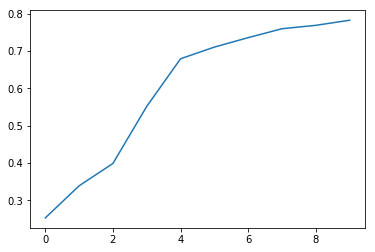

In [209]:
model = logreg(classes=10)
loss_func = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=.01)

def train_(model, train_x, train_y, loss_func, optimizer, epochs=10, batch_size=8):
    losses,itrs = [],0
    tensor_dataset = torch.utils.data.dataset.TensorDataset(train_x,train_y)
    tr_loader = torch.utils.data.DataLoader(dataset=tensor_dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        for i,(batch_x,batch_y) in enumerate(tr_loader):
            batch_x = Variable(batch_x)
            batch_y = Variable(batch_y)

            y_pred = model(batch_x)
            loss = loss_func(y_pred, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itrs+=1
            losses.append(loss.data.numpy()[0])

    return list(range(itrs)), losses

def active_learn(model, train_x, train_y, policy, loss_func, optimizer, val_x, val_y, \
                 epochs_per_train=10, npoints=16, batch_size=8, meta_epochs=10):
    """ Active learning based on a specified policy. """
    # initialy train the model and then based on unlabeled results use the policy to choose more points ans iterate
    total_acc = []
    unlab_x,unlab_y,lab_x,lab_y = get_dataset_split((train_x,train_y), other_size=npoints, \
                                                  random_seed=832)

    for e in range(meta_epochs):
        # Train the model
        itr, losses = train_(model, lab_x, lab_y, loss_func, optimizer, epochs=epochs_per_train, \
                             batch_size=batch_size)
        
        # Get the next points to label 
        unlab_x,unlab_y, addtl_x, addtl_y = get_req_points(model, unlab_x, unlab_y, policy=policy, n=16)
        lab_x, lab_y = torch.cat([lab_x, addtl_x]), torch.cat([lab_y, addtl_y])
 
        # Get accuracy of the model 
        total_acc.append(al.accuracy(model,val_x,val_y))
        
    return list(range(meta_epochs)), total_acc


def get_req_points(model, unlab_x, unlab_y, policy='random', n=16):
    if policy!='random':
        pred_y = model.forward(Variable(unlab_x))
        if policy=='boundary':
            fn = boundary_policy
        elif policy=='uniform':
            fn = uniform_policy
        elif policy=='max_entropy':
            fn = max_entropy_policy
        elif policy=='conf':
            fn = least_confidence_policy
        idxs = fn(pred_y, n=n)
        new_u_x, new_u_y, add_x, add_y = get_idx_split(unlab_x, unlab_y, idxs)
    else: 
        new_u_x, new_u_y, add_x, add_y = get_dataset_split((unlab_x,unlab_y), other_size=n, random_seed=13)
    return new_u_x, new_u_y, add_x, add_y

def boundary_policy(pred_y, n):
    result = al.boundary_proximity(pred_y, num_points=n)
    print(result)
    return result

def get_idx_split(data_x, data_y, idx):
    x1_tensor = torch.cat([data_x[i].view(-1,28,28) for i in idx])
    y1_tensor = torch.LongTensor([data_y[i] for i in idx])
    x2_tensor = torch.cat([data_x[i].view(-1,28,28) for i in range(len(data_y)) if i not in idx])
    y2_tensor = torch.LongTensor([data_y[i] for i in range(len(data_y)) if i not in idx])
    return x2_tensor, y2_tensor, x1_tensor, y1_tensor

def max_entropy_policy(pred_y, n):
    """ Source of math: https://www.cs.cmu.edu/~tom/10701_sp11/recitations/Recitation_13.pdf """
#     print(pred_y.size())
#     print(pred_y)
    probs = torch.exp(pred_y.data)
#     print(probs.size())
#     print(probs)
#     prob_logprob = np.multiply(probs, np.log2(probs))
    prob_logprob = probs*pred_y.data
#     print(prob_logprob.size())
#     print(prob_logprob)
    max_ent = -torch.sum(prob_logprob, dim=1)
#     print(max_ent)
#     print(torch.max(max_ent,0))
#     print(np.max(max_ent.numpy()))
#     print(np.argmax(max_ent))
    max_ent_idxs = al.n_argmax(max_ent, size=n)
#     print(max_ent_idxs)
    return max_ent_idxs

def least_confidence_policy(pred_y, n):
    maxes = torch.max(torch.exp(pred_y.data),1)[0]
    least_conf = 1.0-maxes
    least_conf_idx = al.n_argmax(least_conf, size=n)
    return least_conf_idx

def uniform_policy(pred_y, n):
    cut = n%10
    times = n//10
    _,preds = torch.max(pred_y,dim=1)
    output = []
    for res in range(10): # number of classes
        pred_idx = [idx for idx, elm in enumerate(preds) if elm.data.numpy()[0] == res]
        if len(pred_idx) < (times+1):
            if res<cut:
                output.extend(np.random.choice(range(len(preds)),size=times+1))
            else:
                output.extend(np.random.choice(range(len(preds)),size=times))
            continue
        if res<cut:
            output.extend(np.random.choice(pred_idx, size=times+1))
        else:
            output.extend(np.random.choice(pred_idx, size=times))
    return np.array(output)
    
# itr, acc = train_(model,train_x,train_y)
# itr, acc = train_(model,train_x[:16],train_y[:16],loss_func, optimizer)
res = get_req_points(model, train_x, train_y, policy='max_entropy', n=16)
rrr = get_req_points(model, train_x, train_y, policy='boundary', n=16)
# it, ac = active_learn(model, train_x, train_y, 'boundary', loss_func, optimizer, val_x, val_y, \
#                  epochs_per_train=10, npoints=16, batch_size=8, meta_epochs=10)
plt.plot(it,ac)
print('test_acc',al.accuracy(model,test_x,test_y))

In [151]:
def plot_al_results(meta_epochs, accs, labs): 
    itrs = np.array(list(range(meta_epochs)))
    means, errs = [], []
    for ac in accs:
        means.append(np.mean(ac, axis=0))
        errs.append(np.std(ac,axis=0))

    plt.figure(figsize=(8,8))
    for ac_mean, ac_err, ac_lab in zip(means, errs, labs):
        plt.plot(itrs, ac_mean, label=ac_lab)
        plt.fill_between(itrs, ac_mean+ac_err, ac_mean-ac_err, alpha=0.4)

    plt.title('Accuracy of various active learning policies.')
    plt.xlabel('Meta Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    sns.despine()

In [137]:
########### GLOBAL EXPERIMENT PARAMS ############
# Epochs of adding additional points
meta_epochs = 15
# Epochs per training run
ept = 10 
# Number of points to start with and add each run 
npoints = 16
batch_size = 8
learning_rate = 0.01
# Number of runs to create a sampling distribution to quantify error 
samp_runs = 10

#################################################

# Random 
random_iters, random_acc = [],[]
for i in tqdm(range(samp_runs)):
    model_rand = logreg(classes=10)
    optimizer_rand = optim.SGD(model_rand.parameters(), lr=learning_rate)
    _, rand_acc = active_learn(model_rand, train_x, train_y, 'random', loss_func, optimizer_rand, \
                                        val_x, val_y, epochs_per_train=ept, npoints=npoints, \
                                        batch_size=batch_size, meta_epochs=meta_epochs)
    random_acc.append(rand_acc)
print('Active Learning with random policy done!')

# Boundary
boundary_iters, boundary_acc = [],[]
for i in tqdm(range(samp_runs)):
    model_bound = logreg(classes=10)
    optimizer_bound = optim.SGD(model_bound.parameters(), lr=learning_rate)
    _, bound_acc = active_learn(model_bound, train_x, train_y, 'boundary', loss_func, optimizer_bound, \
                                    val_x, val_y, epochs_per_train=ept, npoints=npoints, \
                                        batch_size=batch_size, meta_epochs=meta_epochs)
    boundary_acc.append(bound_acc)
print('Active Learning with boundary policy done!')



A Jupyter Widget


Active Learning with random policy done!


A Jupyter Widget


Active Learning with boundary policy done!


A Jupyter Widget


Active Learning with boundary policy done!


In [210]:
# Max Entropy
entropy_iters, entropy_acc = [],[]
for i in tqdm(range(samp_runs)):
    model_ent = logreg(classes=10)
    optimizer_ent = optim.SGD(model_ent.parameters(), lr=learning_rate)
    _, ent_acc = active_learn(model_ent, train_x, train_y, 'max_entropy', loss_func, optimizer_ent, \
                                    val_x, val_y, epochs_per_train=ept, npoints=npoints, \
                                        batch_size=batch_size, meta_epochs=meta_epochs)
    entropy_acc.append(ent_acc)
print('Active Learning with maximum entropy policy done!')

A Jupyter Widget


Active Learning with maximum entropy policy done!


In [170]:
# Least Confidence
confidence_acc = []
for i in tqdm(range(samp_runs)):
    model_conf = logreg(classes=10)
    optimizer_conf = optim.SGD(model_conf.parameters(), lr=learning_rate)
    _, conf_acc = active_learn(model_conf, train_x, train_y, 'conf', loss_func, optimizer_conf, \
                                    val_x, val_y, epochs_per_train=ept, npoints=npoints, \
                                        batch_size=batch_size, meta_epochs=meta_epochs)
    confidence_acc.append(conf_acc)
print('Active Learning with least confidence policy done!')

A Jupyter Widget


Active Learning with least confidence policy done!


In [188]:
# Uniform
uniform_acc = []
for i in tqdm(range(samp_runs)):
    model_unif = logreg(classes=10)
    optimizer_unif = optim.SGD(model_unif.parameters(), lr=learning_rate)
    _, unif_acc = active_learn(model_unif, train_x, train_y, 'uniform', loss_func, optimizer_unif, \
                                    val_x, val_y, epochs_per_train=ept, npoints=npoints, \
                                        batch_size=batch_size, meta_epochs=meta_epochs)
    uniform_acc.append(unif_acc)
print('Active Learning with uniform policy done!')

A Jupyter Widget


Active Learning with uniform policy done!


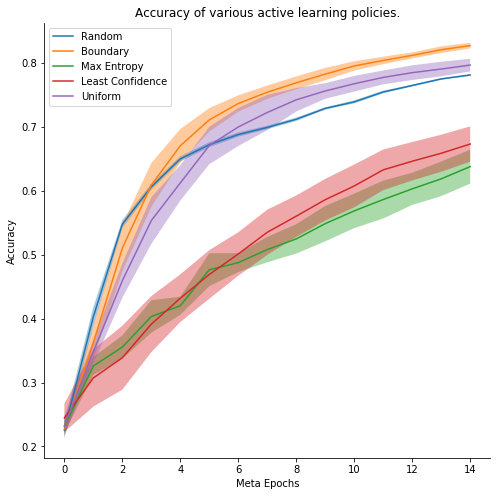

In [211]:
accs = [random_acc,boundary_acc,entropy_acc, confidence_acc,uniform_acc]
labs = ['Random','Boundary','Max Entropy', 'Least Confidence','Uniform']
plot_al_results(meta_epochs,accs,labs)

In [ ]:
# add cluster policy?
# get max entropy and least confidence working

In [156]:
def train_model(model, data_loader, loss_func, optimizer, epochs=10):
    """ Function to train the model """
    losses,itrs = [],0

    for epoch in range(epochs):
        for i,(batch_x,batch_y) in enumerate(data_loader):
            batch_x = Variable(batch_x)
            batch_y = Variable(batch_y)

            y_pred = model(batch_x)
            loss = loss_func(y_pred, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itrs+=1
            losses.append(loss.data.numpy()[0])
            
    # For plotting 
    return list(range(itrs)), losses

def active_learn(model, base_data, train_idx, unlab_idx, policy, loss_func, optimizer, val_loader, \
                 epochs_per_train=10, points_per_itr=16, batch_size=8, meta_epochs=20):
    """ Active learning based on a specified policy. """
    # initialy train the model and then based on unlabeled results use the policy to choose more points ans iterate
    total_acc = []
    train_data, _ = al.get_dataloader(train_idx, [], base_data, batch_size=batch_size)
    unlab_data, _ = al.get_dataloader(unlab_idx, [], base_data, batch_size=len(unlab_idx))
    val_x, val_y = al.get_xy_split(val_loader)
    
    for e in tqdm(range(meta_epochs)):
        # Train the model
        itr, losses = train_model(model, train_data, loss_func, optimizer, epochs=epochs_per_train)
        
        # Get the next points to label and add to training 
        new_points = al.get_requested_points(model, unlab_data, unlab_idx, policy=policy, \
                                             num_points=points_per_itr)
        
        # Get the new DataLoaders based on the selection of the points 
        train_data, train_idx = al.get_dataloader(train_idx, new_points, base_data, batch_size=batch_size)
        unlab_idx = list(set(unlab_idx)-set(new_points))
        unlab_data, unlab_idx = al.get_dataloader(unlab_idx, [], base_data, batch_size=len(unlab_idx))
        
        # Get accuracy of the model 
        total_acc.append(al.accuracy(model,val_x,val_y))
        
    return list(range(meta_epochs)), total_acc


def random_policy(unlab_preds, unlab_idx, num_points):
    return np.random.choice(unlab_idx, size=num_points, replace=False)

def boundary_policy(unlab_preds, unlab_idx, num_points):
    args_boundary = al.boundary_proximity(unlab_preds, num_points)
    policy_idxs = np.array([unlab_idx[i] for i in args_boundary])
    return policy_idxs


def even_policy(unlab_preds, unlab_idx, num_points):
    cut = num_points%10
    times = num_points//10
    _,preds = torch.max(unlab_preds,dim=1)
    output = []
    for res in range(10):
        if res<cut:
            output.extend(np.random.choice([idx for idx, elm in enumerate(preds) \
                                            if elm.data.numpy()[0] == res], size=times+1))
        else:
            output.extend(np.random.choice([idx for idx, elm in enumerate(preds) \
                                            if elm.data.numpy()[0] == res], size=times))
    return np.array(output)


In [178]:
# Define the model
class logreg(nn.Module):
    """ Logistic regression """
    def __init__(self, classes):
        super(logreg, self).__init__()
        self.classes = classes
        self.w = nn.Linear(28*28,classes)
        
    def forward(self, x):
        x = self.w(x.view(-1,1,28*28))
        return nn.functional.log_softmax(x.view(-1,self.classes),dim=1)

